# Phase 1: Basic Momentum Factor

Load AAPL daily prices, compute a 20-day momentum signal, backtest it, and inspect risk metrics.


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt

from qlib.backtesting.engine import Backtester
from qlib.data.loader import DataLoader
from qlib.factors.momentum import Momentum
from qlib.metrics.returns import max_drawdown, sharpe, sortino

plt.style.use("seaborn-v0_8")

In [2]:
symbol = "AAPL"
start = "2015-01-01"

print(f"Loading {symbol} data starting {start}...")
data = DataLoader.load(symbol, start=start)
data.head()

Loading AAPL data starting 2015-01-01...


/Users/josh/alpha/qlib/data/loader.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df: DataFrame = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
datetime,,,,,
2015-01-02,24.694243,24.705328,23.798608,24.237558,212818400
2015-01-05,24.006990,24.086799,23.368519,23.554739,257142000
2015-01-06,23.619038,23.816344,23.195606,23.556965,263188400
2015-01-07,23.765352,23.987044,23.654506,23.887283,160423600
2015-01-08,24.215383,24.862723,24.097885,24.805082,237458000


In [3]:
lookback = 20
factor = Momentum(lookback=lookback)

signal = factor.compute(data)
print(f"Signal name: {signal.name or 'momentum'}; lookback={lookback}")
signal.tail()

Signal name: momentum; lookback=20


datetime
2025-11-14    0.080796
2025-11-17    0.020894
2025-11-18    0.018759
2025-11-19    0.040125
2025-11-20    0.026690
Name: momentum, dtype: float64

In [4]:
bt = Backtester(data["close"])
rets = bt.run(signal).dropna()

metrics = {
    "sharpe": sharpe(rets),
    "sortino": sortino(rets),
    "max_drawdown": max_drawdown(rets),
}
metrics

{'sharpe': np.float64(0.2028550288614428),
 'sortino': np.float64(0.2616948883653839),
 'max_drawdown': np.float64(-0.06479905087654034)}

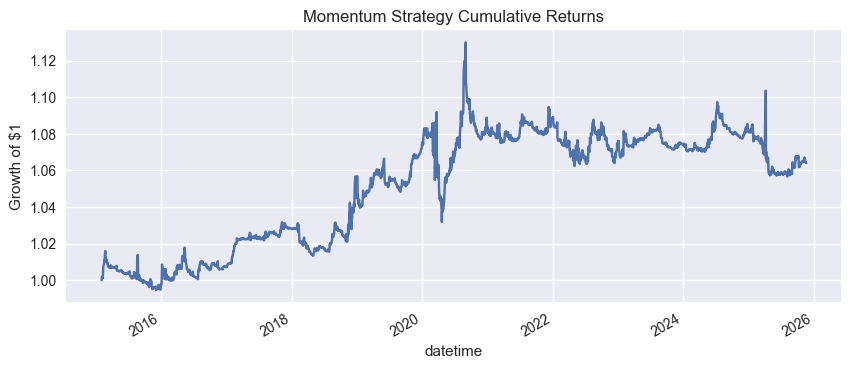

In [5]:
cum_rets = (1 + rets).cumprod()
ax = cum_rets.plot(figsize=(10, 4), title="Momentum Strategy Cumulative Returns")
ax.set_ylabel("Growth of $1")
plt.show()